# Scrub our Roller Coaster Data pulled from Wiki

In [190]:
import pandas as pd
import numpy as np
from dataprep.clean import clean_lat_long
from dataprep.clean import clean_date
import plotly.express as px
import matplotlib.pylab as plt
pd.set_option('max_columns', 500)

In [14]:
coaster = pd.read_csv('coaster_db_v1.csv', low_memory=False, index_col=[0])
coaster = coaster.reset_index()

coaster['coords_v1'] = coaster['Coordinates'].str.split('\ufeff', expand=True)[4]
coaster['lat_v1'] = coaster['coords_v1'].str.split(' ', expand=True)[0]
coaster['lon_v1'] = coaster['coords_v1'].str.split(' ', expand=True)[1]
coaster = clean_lat_long(coaster, lat_long='coords_v1', report=False, split=True)
coaster['Location'] = coaster['Location'].fillna('Other')

In [19]:
coaster['Type'] = coaster['Type'].fillna('Other')
coaster['Type_Main'] = coaster['Type'] \
    .str.split('–', expand=True)[0] \
    .str.strip().replace('','Other') \
    .str.replace('Steel junior roller coaster','Steel')

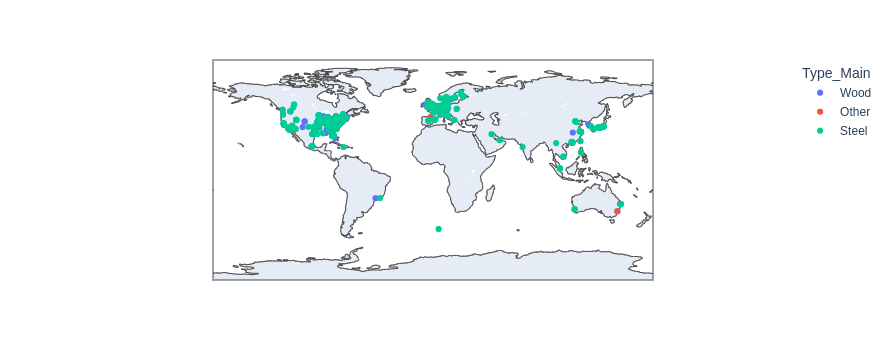

In [22]:
# df = px.data.gapminder().query("year == 2007")
fig = px.scatter_geo(coaster, lat='latitude',
                     lon='longitude',
                     color='Type_Main'
                    )
fig.show()

In [56]:
coaster['opening_date_clean'] = coaster['Opening date'].str.split(';').str[0]

In [100]:
coaster['opening_date_clean'] = coaster['opening_date_clean'] \
    .str.replace('1950s','1950') \
    .str.replace('[1]','', regex=False) \
    .str.replace(' (original)July 15, 2005 (reopening)','', regex=False) \
    .str.replace('  as Runaway Train 19 March 2014 as Scorpion Express ','', regex=False) \
    .str.replace('February 8, 2001June 23, 2018','February 8, 2001', regex=False) \
    .str.replace('1984Opened10 March 2007Reopened','1984', regex=False) \
    .str.replace('1985 (original)1993 (current location)','1985', regex=False) \
    .str.replace(' as Blauer Enzian, 1986 as Thunder Run','', regex=False) \
    .str.replace('1984Opened10 March 2007Reopened','1984', regex=False) \
    .str.replace('7 June 1987 as Runaway Train 19 March 2014 as Scorpion Express','7 June 1987', regex=False)
    # .str.replace(' as Blauer Enzian, 1986 as Thunder Run','', regex=False) \

In [141]:
coaster['Speed'] = coaster['Speed'].str.replace('\xa0',' ')
coaster['speed1'] = coaster['Speed'] \
    .str.replace('[1]','', regex=False) \
    .str.replace('[2]','', regex=False) \
    .str.split('(').str[0]
coaster['speed2'] = coaster['Speed'] \
    .str.replace('[1]','', regex=False) \
    .str.replace('[2]','', regex=False) \
    .str.split('(').str[1] \
    .str.replace(')','', regex=False)

In [148]:
coaster['speed1_value'] = coaster['speed1'].str.split(' ').str[0].astype('float')
coaster['speed1_unit'] = coaster['speed1'].str.split(' ').str[1]

In [150]:
coaster['speed1_unit'].value_counts()

mph     780
km/h    157
Name: speed1_unit, dtype: int64

In [166]:
KMH_MPH = 0.6213711922

coaster['speed_mph'] = np.nan
coaster.loc[coaster['speed1_unit'] == 'mph', 'speed_mph'] = \
    coaster.loc[coaster['speed1_unit'] == 'mph']['speed1_value']
coaster.loc[coaster['speed1_unit'] == 'km/h', 'speed_mph'] = \
    coaster.loc[coaster['speed1_unit'] == 'km/h']['speed1_value'] * KMH_MPH
coaster['speed_mph'] = coaster['speed_mph'].round(1)

Text(0.5, 0, 'mph')

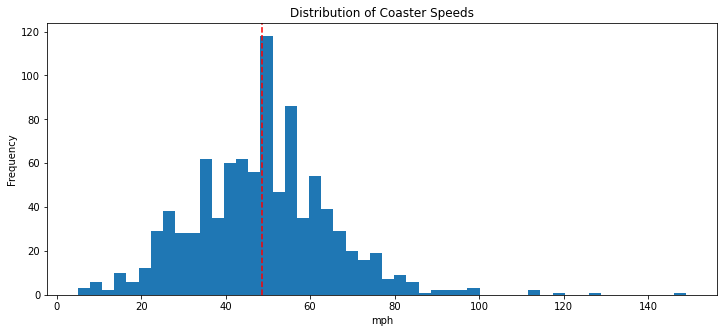

In [181]:
ax = coaster['speed_mph'].plot(kind='hist', bins=50,
                          title='Distribution of Coaster Speeds',
                              figsize=(12, 5))
ax.axvline(coaster['speed_mph'].mean(), color='red', ls='--')
ax.set_xlabel('mph')

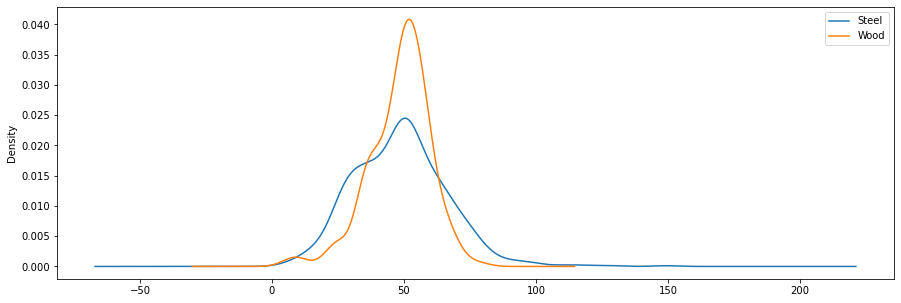

In [197]:
coaster.query('Type_Main != "Other"') \
    .groupby('Type_Main')['speed_mph'].plot(kind='kde', figsize=(15, 5))
plt.legend()

In [201]:
speed_cols = [c for c in coaster.columns if 'speed' in c.lower()]
coaster.query('speed_mph > 140')[speed_cols]

,Speed,speed1,speed2,speed1_unit,speed1_value,speed_mph
814,240 km/h (149.1 mph),240 km/h,149.1 mph,km/h,240.0,149.1


In [207]:
coaster.to_csv('coaster_db_v2.csv')

In [211]:
# coaster.head()

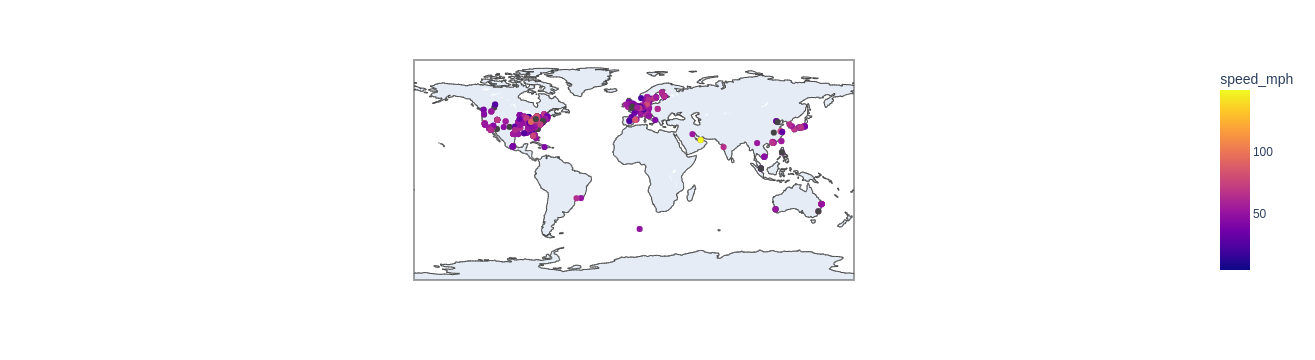

In [218]:
fig = px.scatter_geo(coaster, lat='latitude',
                     lon='longitude',
                     color='speed_mph',
                     hover_name='coaster_name', 
                    )
fig.show()